In [51]:
#@title
# !kill -9 -1
! pip install pydrive

# these classes allow you to request the Google drive API
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth 
from oauth2client.client import GoogleCredentials
from google.colab import files

import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
from sklearn.metrics import fbeta_score, accuracy_score, log_loss 
from sklearn.externals import joblib
from keras.models import load_model, Model
from keras.models import model_from_json
from  keras import backend as K
from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt
import cv2

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

to_download = {    
    'train.csv' : '10ObsG1CBpM6TM79h-Z6qJ04Xv44-iwBE',
    'test.csv' : '1WwInc3YPCw8ZUHmZms6oNjSIFBLr2RUd',
    'validation.csv' : '1e6RrqxJZvaOu7kwkItjb5OAa_E6grEpK',
    'xgboost.dat' : '1d14Z7rcopZ_C89dOPLTtFLtfPpjqCmxL'
}

for filename, fileid in to_download.items():
  drive.CreateFile({'id': fileid}).GetContentFile(filename)

In [0]:
df = pd.read_csv('validation.csv')
df.drop(df.columns[0], axis=1, inplace=True)

In [0]:
df.columns = [f'f{i}' if i < 63 else f'out{i}' for i in range(70)]

In [0]:
x_validation, y_validation = df.loc[:, 'f0':'f62'], df.loc[:, 'out63':'out69']

In [58]:
x_validation.shape, y_validation.shape

((3589, 63), (3589, 7))

In [0]:
model = joblib.load("xgboost.dat")

In [60]:
y_pred = model.predict(x_validation)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [0]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()

In [62]:
y_pred = lb.fit_transform(y_pred)
y_pred.shape

(3589, 7)

In [63]:
score = fbeta_score(y_validation, y_pred, beta=1, average='micro')
score

0.7174700473669546

In [64]:
score = accuracy_score(y_validation, y_pred)
score

0.7174700473669546

In [65]:
score = log_loss(y_validation, y_pred)
score

9.758238858857467

[Text(191,0.5,'True label'), Text(0.5,173,'Predicted label')]

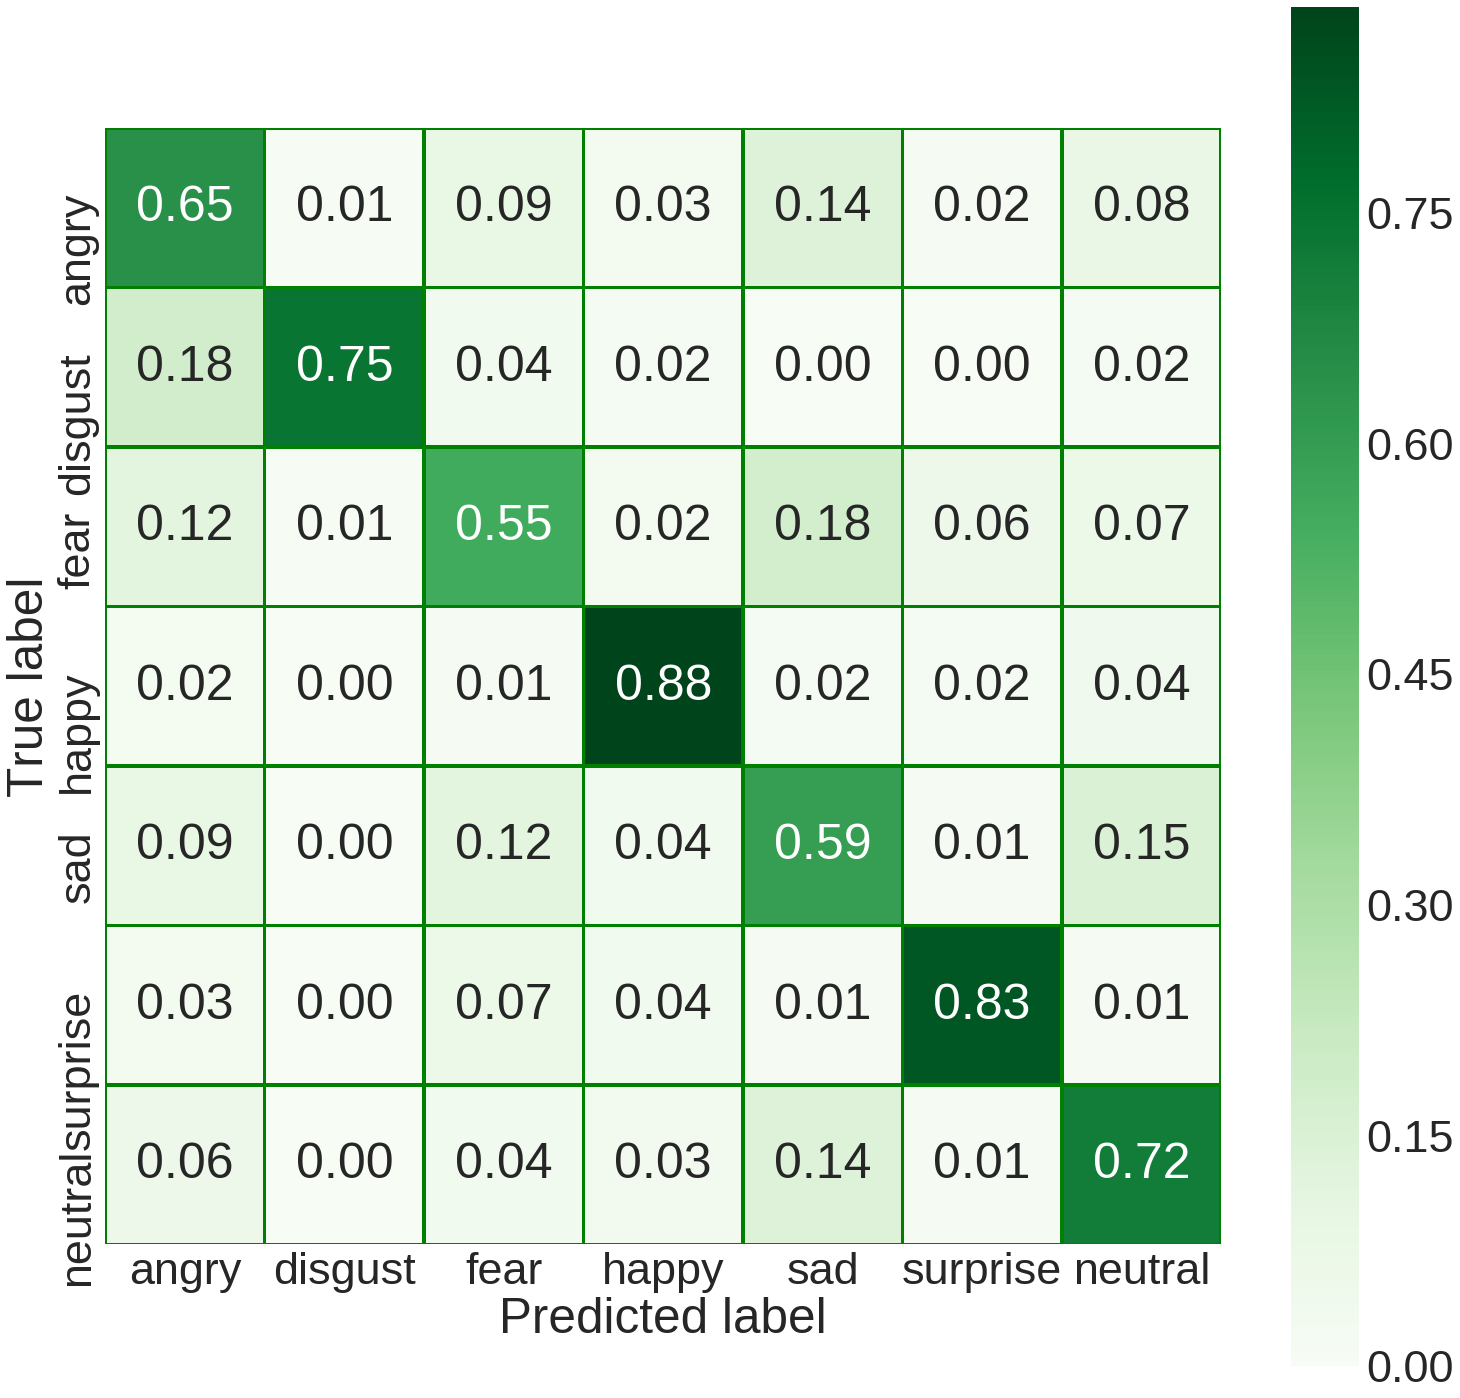

In [48]:
# Plot a confusion matrix
emotions_text = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

cm = confusion_matrix([np.argmax(i) for i in np.array(y_validation)], [np.argmax(i) for i in np.array(y_pred)])
cm_normalised = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.set(font_scale=4.5) 
fig, ax = plt.subplots(figsize=(25, 25))
ax = sns.heatmap(cm_normalised, annot=True, linewidths=2.5, square=True, linecolor="Green", 
                    cmap="Greens", yticklabels=emotions_text, xticklabels=emotions_text, vmin=0, vmax=np.max(cm_normalised), 
                    fmt=".2f", annot_kws={"size": 50})
ax.set(xlabel='Predicted label', ylabel='True label')
# fig.savefig(MODEL_BASE_NAME + '_accuracy.png')